In [2]:
!pip install git+https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git
!pip install tabulate


  Cloning https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git to /tmp/pip-req-build-4r_6q7al
  Running command git clone --filter=blob:none --quiet https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git /tmp/pip-req-build-4r_6q7al
  Resolved https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git to commit ca2797e9270195313423324c9d0f205f6cbb3d28
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.8/953.8 kB 3.7 MB/s eta 0:00:00
  Created wheel for text-flappy-bird-gym: filename=text_flappy_bird_gym-0.1.1-py3-none-any.whl size=7772 sha256=2de7fa357eae25d0ea239230eb6fd6caa1d0b3197b11a5b387fee5c2af6c0b1c
  Stored in directory: /tmp/pip-ephem-wheel-cache-uskfn_qz/wheels/41/44/75/c67b96ba782472d8cacb00e3af57e29d1ee3a14f2e95a59ce5
Successfully built text-flappy-bird-gym


In [3]:
import numpy as np
from scipy.stats import sem
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from numpy.random import randn
from scipy import array, newaxis
from IPython.display import clear_output
import os, sys
import gym
import time
import text_flappy_bird_gym
from tqdm import tqdm
import pickle
from collections import defaultdict
from mpl_toolkits.mplot3d import axes3d
import gymnasium as gym
from tabulate import tabulate
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
from tqdm import tqdm

### Sarsa(λ) Agent

In [4]:
class SarsaLambdaAgent:
    def __init__(self, n_actions, eps=0.1, alpha=0.5, gamma=0.99, lambd=0.9):
        self.eps = eps
        self.alpha = alpha
        self.gamma = gamma
        self.lambd = lambd
        self.n_actions = n_actions
        self.q_table = defaultdict(lambda: np.zeros(n_actions))
        self.e_table = defaultdict(lambda: np.zeros(n_actions))  # Eligibility traces

    def choose_action(self, state):
        if np.random.rand() < self.eps:
            return np.random.choice(self.n_actions)
        else:
            return np.argmax(self.q_table[state])

    def learn(self, state, action, reward, next_state, next_action, done):
        predict = self.q_table[state][action]
        target = reward + self.gamma * self.q_table[next_state][next_action] * (not done)
        td_error = target - predict

        # Increment the eligibility trace for the visited state-action pair
        self.e_table[state][action] += 1

        # Update Q-values and decay eligibility traces for all state-action pairs
        for s, actions in self.q_table.items():
            for a in range(len(actions)):
                self.q_table[s][a] += self.alpha * td_error * self.e_table[s][a]
                self.e_table[s][a] *= self.gamma * self.lambd

    def reset_e_table(self):
        self.e_table = defaultdict(lambda: np.zeros(self.n_actions))


def train_sarsa_lambda_agent(agent, env, n_episodes):
    rewards = []  # Track rewards for each episode
    scores = []  # Track scores for each episode
    max_score = 1500
    for episode in tqdm(range(n_episodes), desc="Training Episodes"):
        total_reward = 0
        state = env.reset()
        done = False
        action = agent.choose_action(str(state))

        agent.reset_e_table()  # Reset eligibility traces for the new episode

        while not done:
            next_state, reward, done, _,info = env.step(action)
            next_action = agent.choose_action(str(next_state))
            agent.learn(str(state), action, reward, str(next_state), next_action, done)
            state = next_state
            action = next_action
            total_reward += reward
            if info['score'] >= max_score:
              break

        rewards.append(total_reward)
        scores.append(info['score'])
    return rewards,scores




/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Baseline

Training Episodes: 100%|██████████| 10000/10000 [10:48<00:00, 15.41it/s]


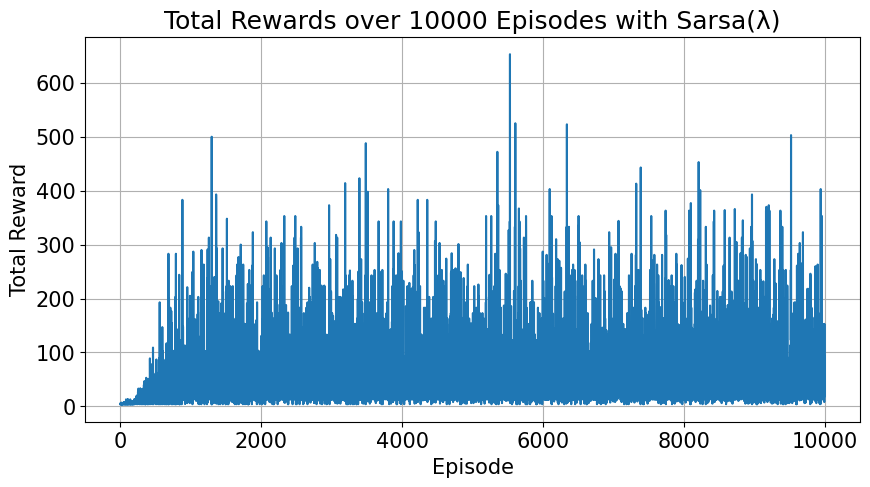

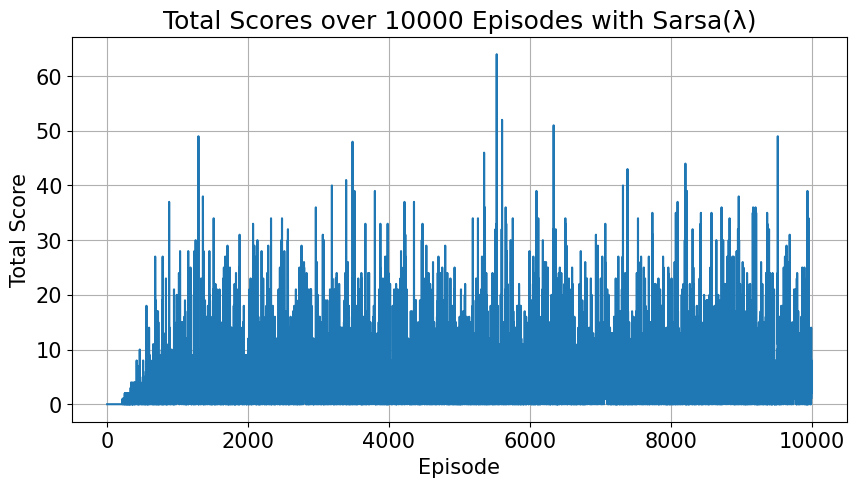

In [141]:
env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)

n_episodes = 10000
agent = SarsaLambdaAgent(n_actions=2)
rewards,scores = train_sarsa_lambda_agent(agent, env, n_episodes)

# Plot the rewards
plt.figure(figsize=(10, 5))
plt.plot(rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title(f"Total Rewards over {n_episodes} Episodes with Sarsa(λ)")
plt.grid(True)
plt.show()


# Plot the scores
plt.figure(figsize=(10, 5))
plt.plot(scores)
plt.xlabel("Episode")
plt.ylabel("Total Score")
plt.title(f"Total Scores over {n_episodes} Episodes with Sarsa(λ)")
plt.grid(True)
plt.show()

#### HyperParameter Tuning

##### Step Size

In [142]:
# Define the different step sizes to test
step_sizes = [0.1, 0.2, 0.3, 0.4]
labels = ["alpha = " + str(alpha) for alpha in step_sizes]

# Initialize the environment
env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)

# Containers for storing scores and rewards
all_rewards = []

# Loop over each step size
for alpha in step_sizes:
    n_episodes = 10000
    # Initialize SarsaLambdaAgent with the current step size
    agent = SarsaLambdaAgent(n_actions=2, eps=0.1, alpha=alpha, gamma=0.99, lambd=0.9)

    # Train the SarsaLambdaAgent
    rewards, scores = train_sarsa_lambda_agent(agent, env, n_episodes)
    all_rewards.append(rewards)


Training Episodes: 100%|██████████| 10000/10000 [09:25<00:00, 17.68it/s]


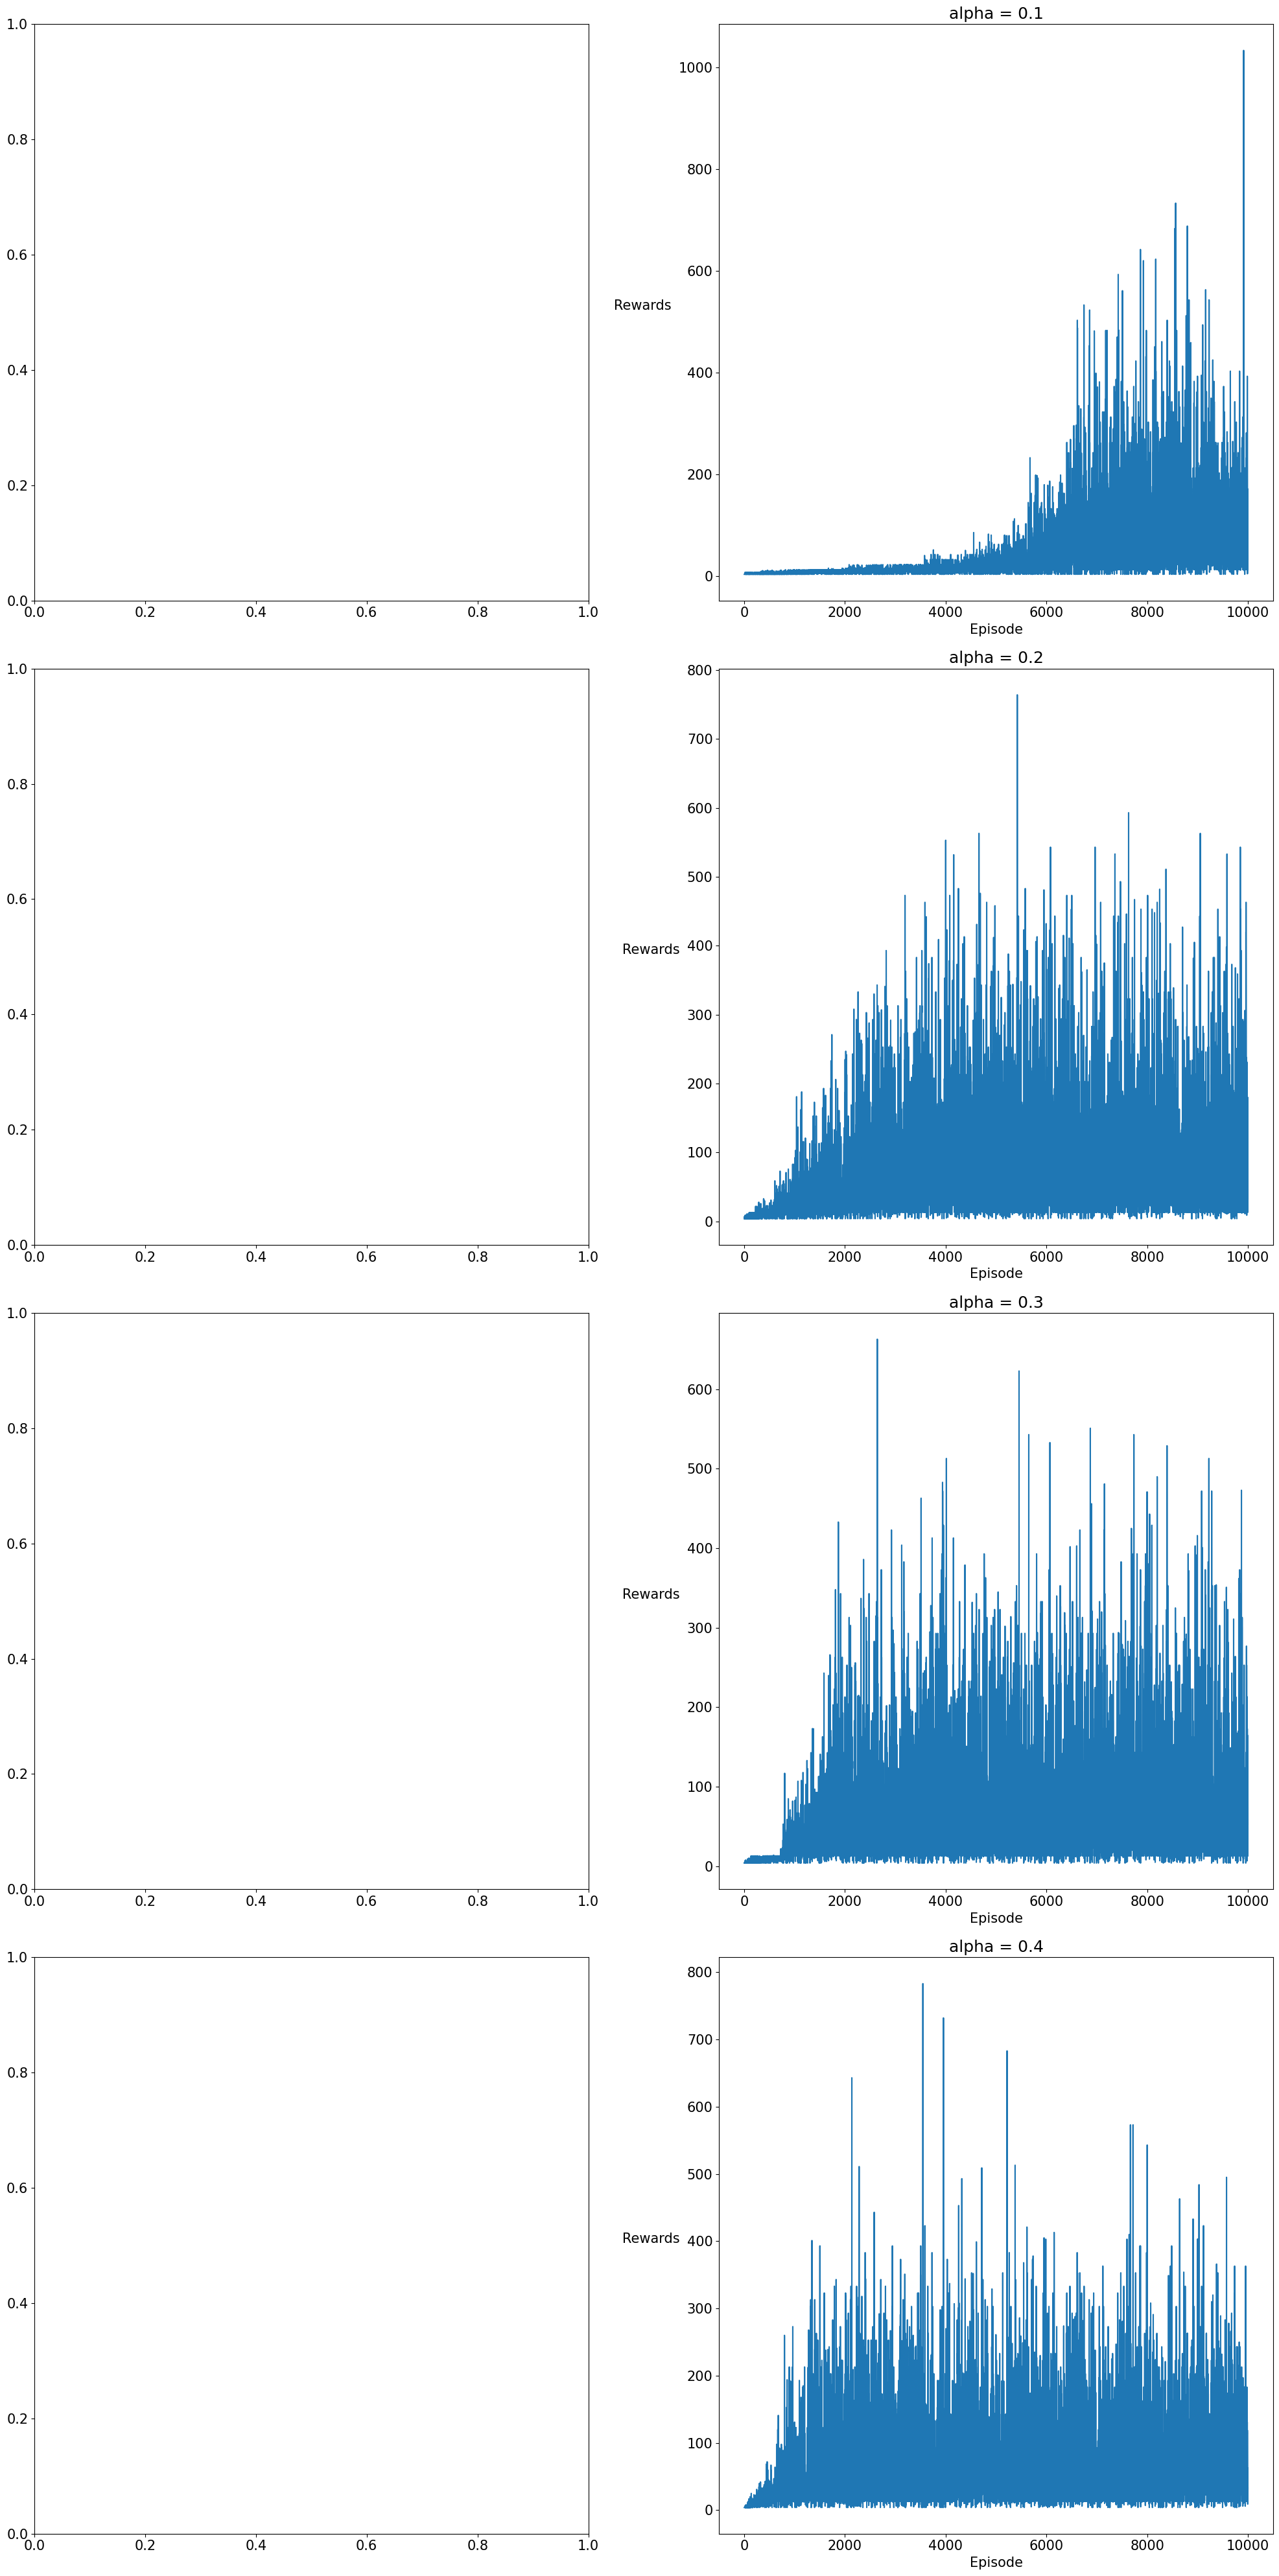

╒═════════════╤═════════════════╤═══════════════════╤════════════════╕
│ Label       │   Mean(Rewards) │   Median(Rewards) │   Max(Rewards) │
╞═════════════╪═════════════════╪═══════════════════╪════════════════╡
│ alpha = 0.1 │         44.4997 │                16 │           1033 │
├─────────────┼─────────────────┼───────────────────┼────────────────┤
│ alpha = 0.2 │         74.2312 │                48 │            764 │
├─────────────┼─────────────────┼───────────────────┼────────────────┤
│ alpha = 0.3 │         67.4198 │                43 │            663 │
├─────────────┼─────────────────┼───────────────────┼────────────────┤
│ alpha = 0.4 │         66.2173 │                43 │            783 │
╘═════════════╧═════════════════╧═══════════════════╧════════════════╛


In [143]:
# Now, plot the rewards  each alpha
num_rows = len(labels)
num_cols = 2

fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 10 * num_rows))

for i, alpha in enumerate(step_sizes):

    axs[i, 1].plot(all_rewards[i])
    axs[i, 1].set_xlabel("Episode")
    axs[i, 1].set_ylabel("Rewards", rotation=0, labelpad=40)
    axs[i, 1].set_title(labels[i])

fig.tight_layout()
plt.show()

reward_headers = ["Label", "Mean(Rewards)", "Median(Rewards)", "Max(Rewards)"]
reward_rows = []

for i, label in enumerate(labels):
    reward_rows.append([label, np.mean(all_rewards[i]), np.median(all_rewards[i]), np.max(all_rewards[i])])

reward_table = tabulate(reward_rows, headers=reward_headers, tablefmt='fancy_grid')
print(reward_table)

##### Epsilon

Training Episodes: 100%|██████████| 10000/10000 [04:39<00:00, 35.77it/s]


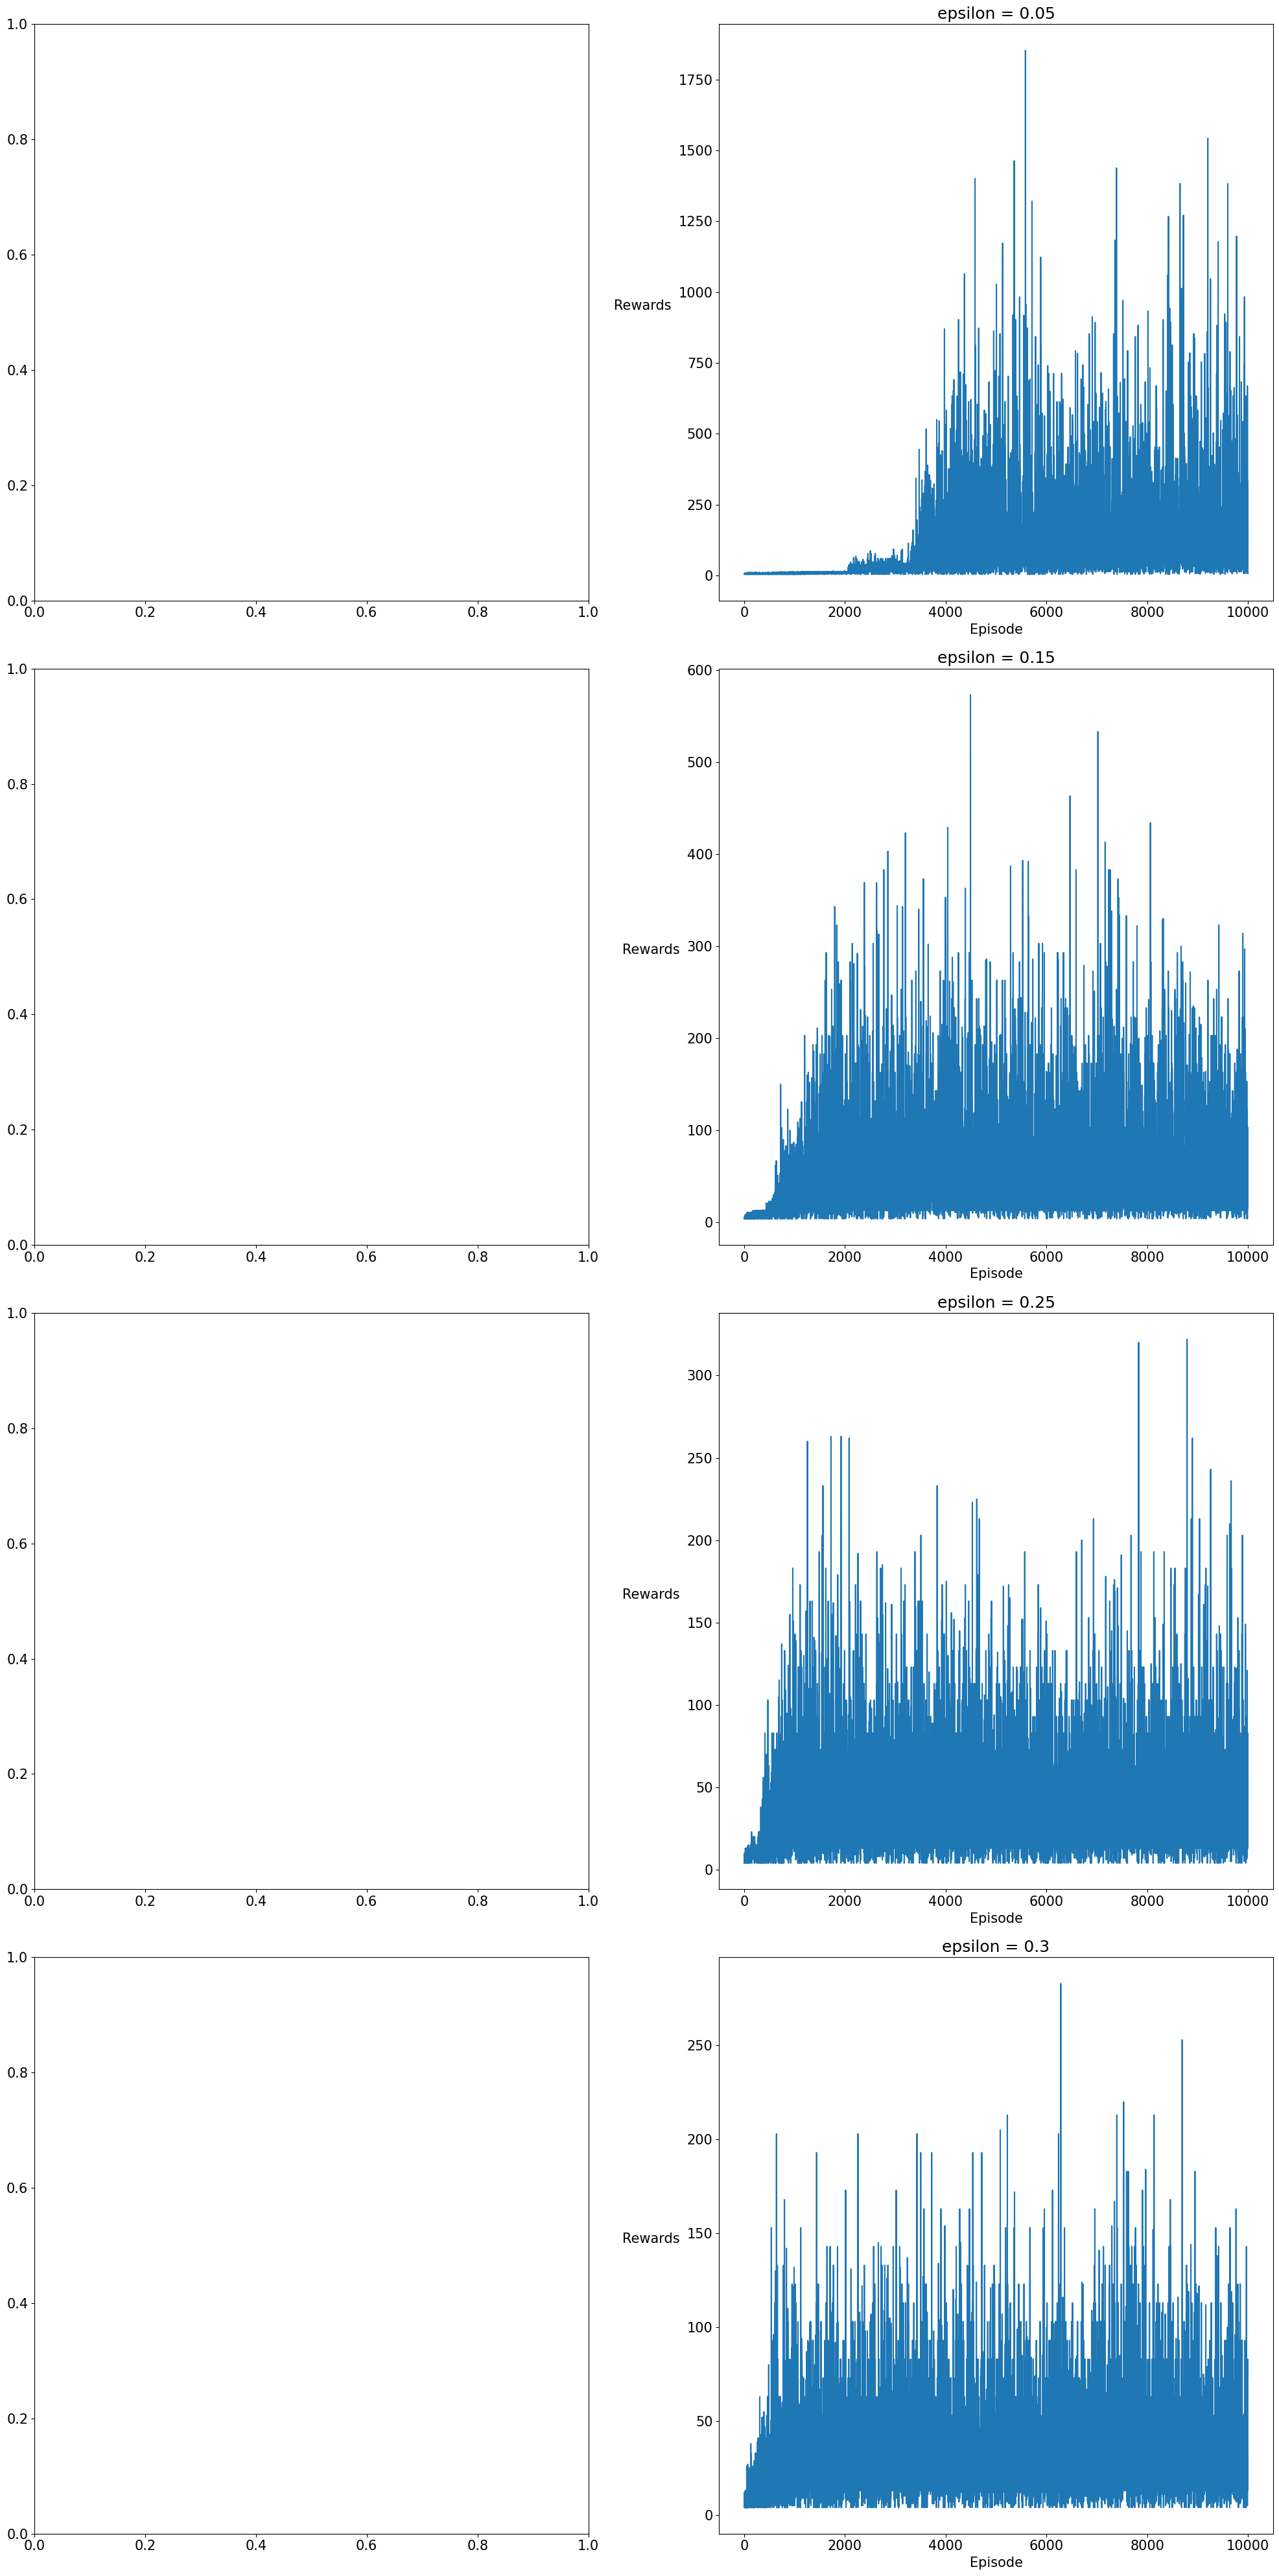

Epsilon Tuning Results:
╒════════════════╤═════════════════╤═══════════════════╤════════════════╕
│ Label          │   Mean(Rewards) │   Median(Rewards) │   Max(Rewards) │
╞════════════════╪═════════════════╪═══════════════════╪════════════════╡
│ epsilon = 0.05 │        103.393  │                44 │           1853 │
├────────────────┼─────────────────┼───────────────────┼────────────────┤
│ epsilon = 0.15 │         55.2673 │                37 │            573 │
├────────────────┼─────────────────┼───────────────────┼────────────────┤
│ epsilon = 0.25 │         37.2079 │                26 │            322 │
├────────────────┼─────────────────┼───────────────────┼────────────────┤
│ epsilon = 0.3  │         31.8476 │                23 │            283 │
╘════════════════╧═════════════════╧═══════════════════╧════════════════╛


In [145]:
# Define the different epsilon values to test
epsilons = [0.05, 0.15, 0.25, 0.3]
labels = ["epsilon = " + str(eps) for eps in epsilons]

# Initialize the environment
env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)

# Containers for storing scores and rewards
all_rewards = []
best_alpha = 0.2
# Loop over each epsilon value
for eps in epsilons:
    n_episodes = 10000
    # Initialize SarsaLambdaAgent with the current epsilon
    agent = SarsaLambdaAgent(n_actions=2, eps=eps, alpha=best_alpha, gamma=0.99, lambd=0.9)

    # Train the SarsaLambdaAgent and collect rewards
    rewards,scores = train_sarsa_lambda_agent(agent, env, n_episodes)
    all_rewards.append(rewards)


# Plotting the performance for each epsilon
num_rows = len(labels)
num_cols = 2

fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 10 * num_rows))

for i, eps in enumerate(epsilons):


    axs[i, 1].plot(all_rewards[i])
    axs[i, 1].set_xlabel("Episode")
    axs[i, 1].set_ylabel("Rewards", rotation=0, labelpad=40)
    axs[i, 1].set_title(labels[i])

fig.tight_layout()
plt.show()

# Print out summary tables for rewards and scores
print("Epsilon Tuning Results:")

reward_headers = ["Label", "Mean(Rewards)", "Median(Rewards)", "Max(Rewards)"]
reward_rows = []

for i, label in enumerate(labels):
    reward_rows.append([label, np.mean(all_rewards[i]), np.median(all_rewards[i]), np.max(all_rewards[i])])

reward_table = tabulate(reward_rows, headers=reward_headers, tablefmt='fancy_grid')
print(reward_table)



##### Gamma

Training Episodes: 100%|██████████| 10000/10000 [12:49<00:00, 13.00it/s]


The best gamma based on the highest mean reward is gamma = 1.0 with a mean reward of 107.4227


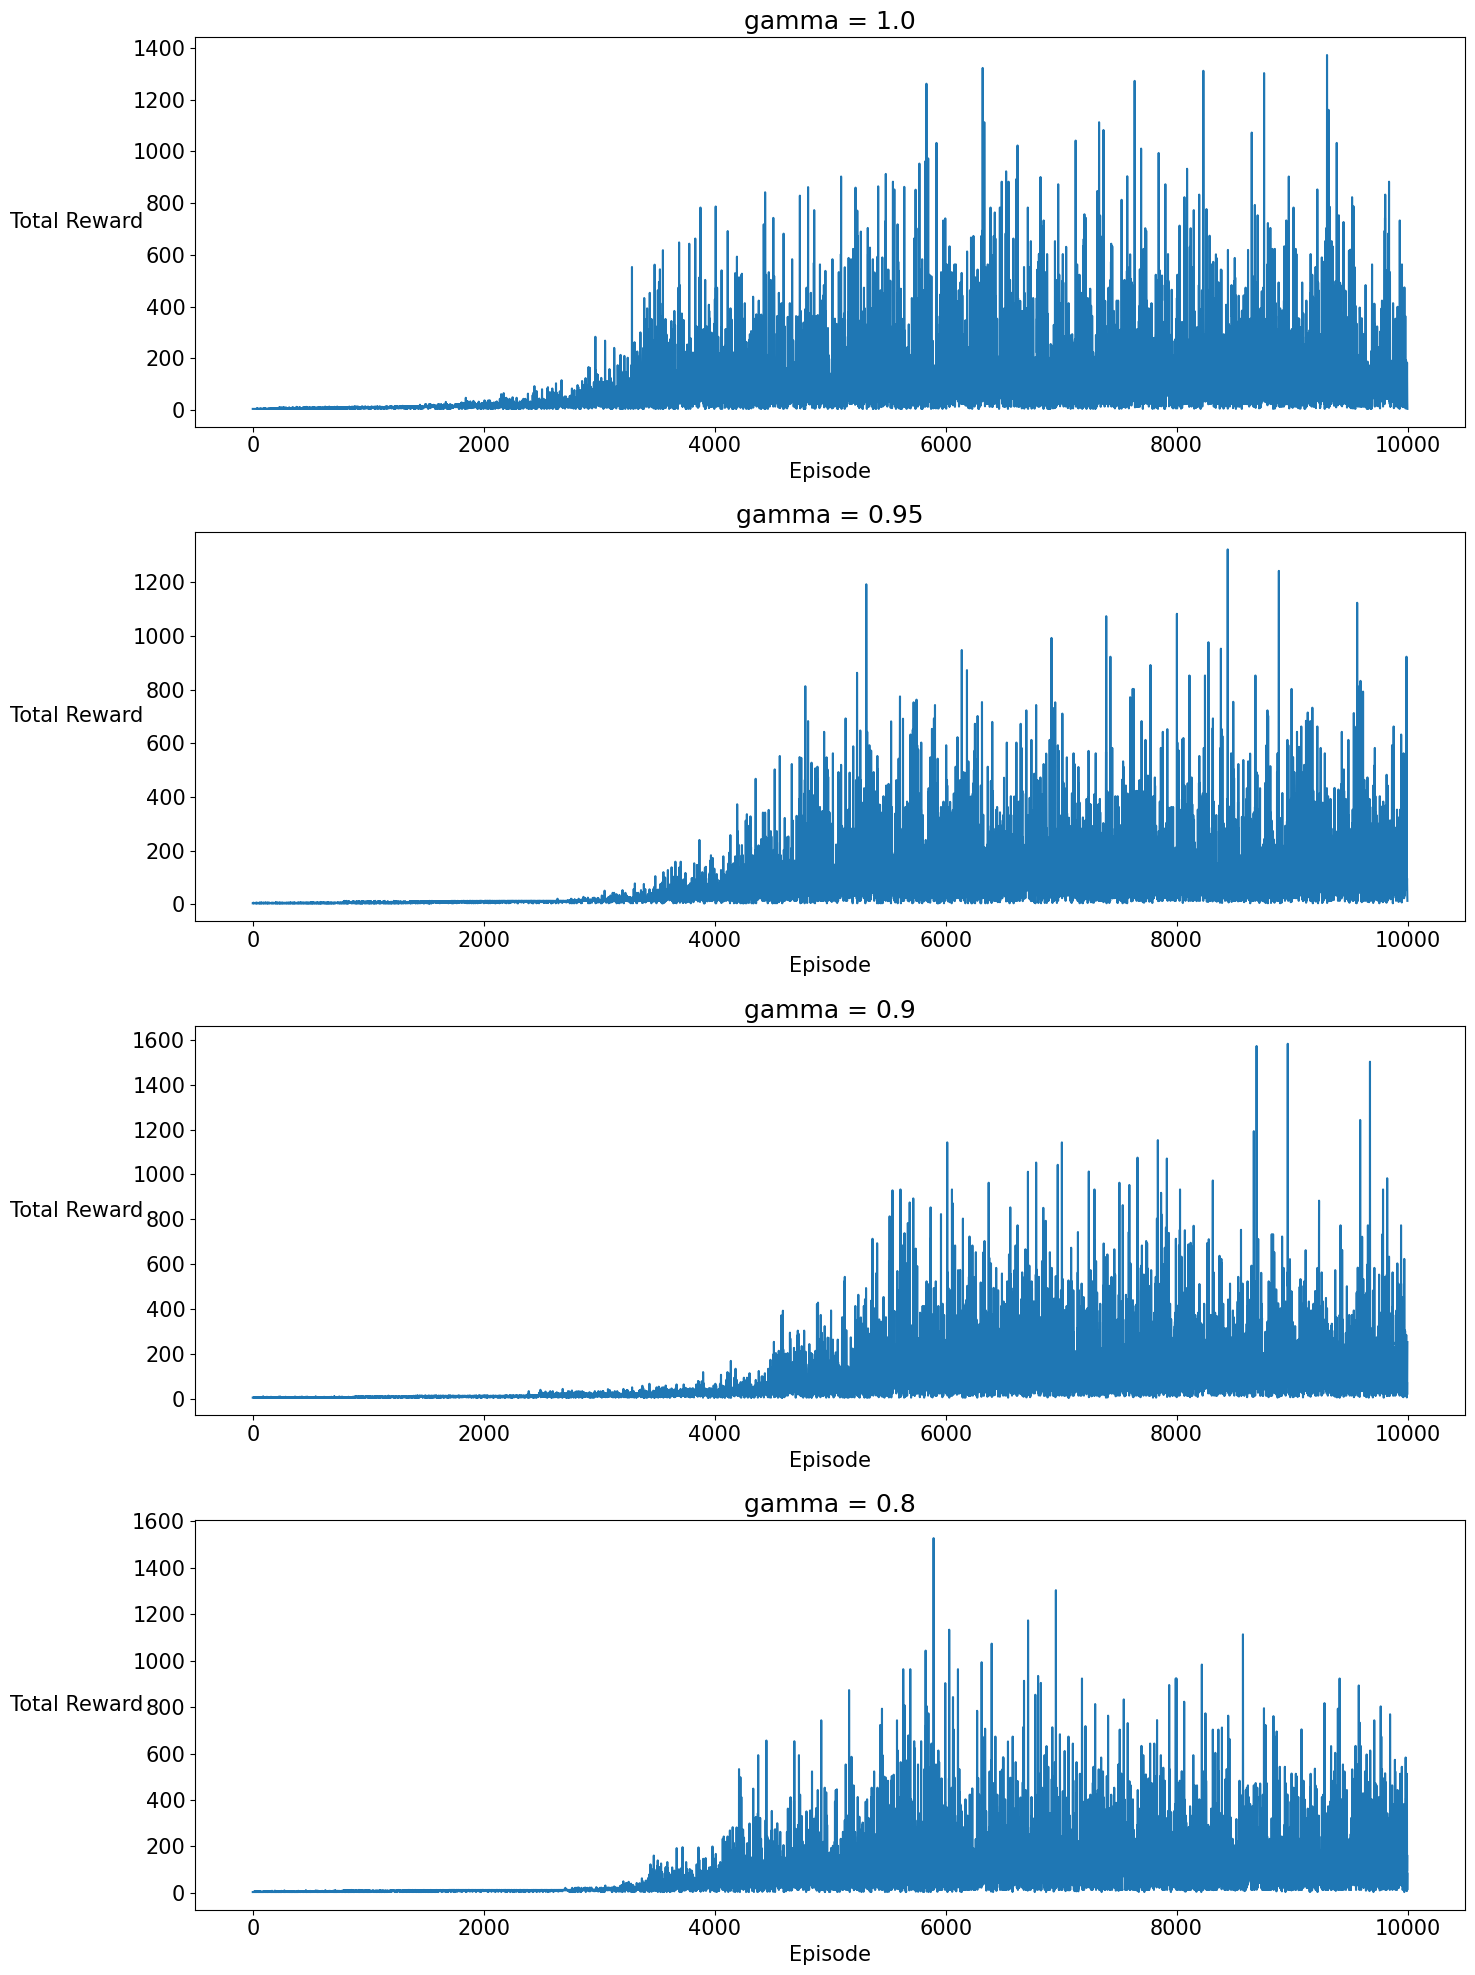

╒══════════════╤═════════════════╤═══════════════════╤════════════════╕
│ Label        │   Mean(Rewards) │   Median(Rewards) │   Max(Rewards) │
╞══════════════╪═════════════════╪═══════════════════╪════════════════╡
│ gamma = 1.0  │        107.423  │                50 │           1373 │
├──────────────┼─────────────────┼───────────────────┼────────────────┤
│ gamma = 0.95 │         87.71   │                33 │           1323 │
├──────────────┼─────────────────┼───────────────────┼────────────────┤
│ gamma = 0.9  │         90.7248 │                32 │           1583 │
├──────────────┼─────────────────┼───────────────────┼────────────────┤
│ gamma = 0.8  │         91.6513 │                36 │           1527 │
╘══════════════╧═════════════════╧═══════════════════╧════════════════╛


In [147]:
# Define the different discount factors to test
discount_factors = [1.0, 0.95, 0.9, 0.8]
labels = ["gamma = " + str(gamma) for gamma in discount_factors]

# Initialize the environment
env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)

all_rewards = []

best_alpha = 0.2
best_epsilon = 0.05

# Loop over each discount factor
for gamma in discount_factors:
    n_episodes = 10000
    agent = SarsaLambdaAgent(n_actions=2, eps=best_epsilon, alpha=best_alpha, gamma=gamma, lambd=0.9)

    rewards,scores = train_sarsa_lambda_agent(agent, env, n_episodes)
    all_rewards.append(rewards)

# Find the best gamma
mean_rewards = [np.mean(rewards) for rewards in all_rewards]
best_gamma_index = np.argmax(mean_rewards)
best_gamma = discount_factors[best_gamma_index]
best_gamma_label = labels[best_gamma_index]

print(f"The best gamma based on the highest mean reward is {best_gamma_label} with a mean reward of {mean_rewards[best_gamma_index]}")

# Plotting the performance for each gamma
num_rows = len(labels)
num_cols = 1

fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

for i, gamma in enumerate(discount_factors):
    axs[i].plot(all_rewards[i])
    axs[i].set_xlabel("Episode")
    axs[i].set_ylabel("Total Reward", rotation=0, labelpad=40)
    axs[i].set_title(labels[i])

fig.tight_layout()
plt.show()

# Print out summary table for rewards
reward_headers = ["Label", "Mean(Rewards)", "Median(Rewards)", "Max(Rewards)"]
reward_rows = []

for i, label in enumerate(labels):
    reward_rows.append([label, np.mean(all_rewards[i]), np.median(all_rewards[i]), np.max(all_rewards[i])])

reward_table = tabulate(reward_rows, headers=reward_headers, tablefmt='fancy_grid')
print(reward_table)


##### Lambda

Training Episodes: 100%|██████████| 10000/10000 [08:00<00:00, 20.81it/s]


The best lambda based on the highest mean reward is lambda = 0.3 with a mean reward of 70.8041


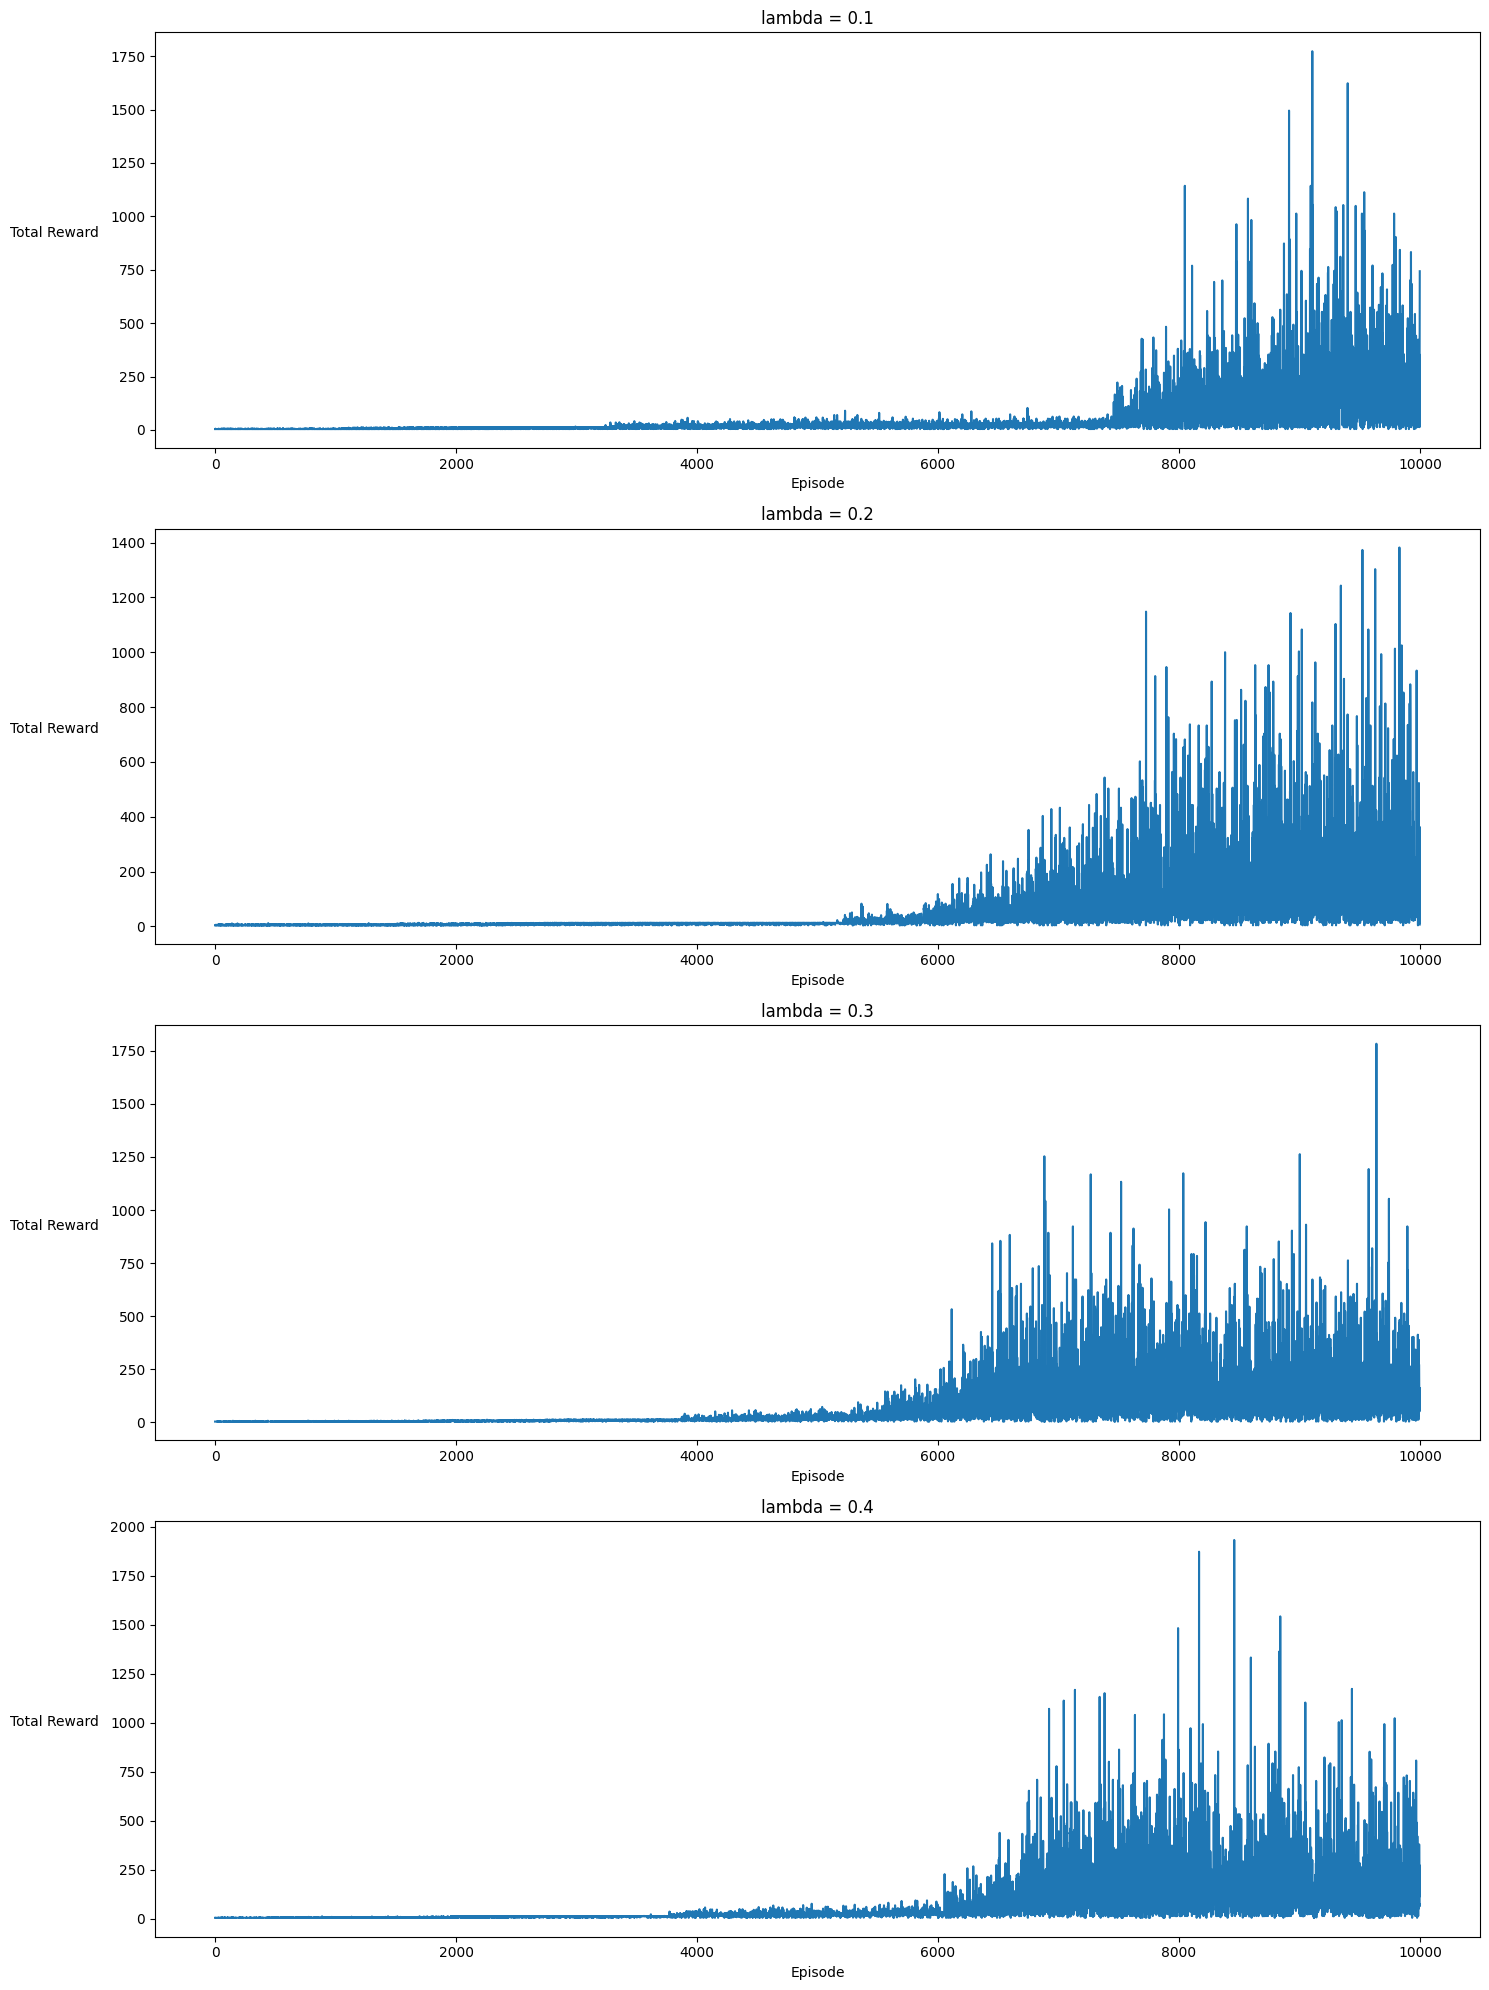

╒══════════════╤═════════════════╤═══════════════════╤════════════════╕
│ Label        │   Mean(Rewards) │   Median(Rewards) │   Max(Rewards) │
╞══════════════╪═════════════════╪═══════════════════╪════════════════╡
│ lambda = 0.1 │         47.1676 │                16 │           1773 │
├──────────────┼─────────────────┼───────────────────┼────────────────┤
│ lambda = 0.2 │         61.2772 │                13 │           1382 │
├──────────────┼─────────────────┼───────────────────┼────────────────┤
│ lambda = 0.3 │         70.8041 │                17 │           1783 │
├──────────────┼─────────────────┼───────────────────┼────────────────┤
│ lambda = 0.4 │         69.6224 │                18 │           1933 │
╘══════════════╧═════════════════╧═══════════════════╧════════════════╛


In [5]:
# Define the different lambda values to test
lambda_values = [0.1, 0.2, 0.3, 0.4]
labels = ["lambda = " + str(lambd) for lambd in lambda_values]

# Initialize the environment
env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)

# Containers for storing the performance metrics
all_rewards = []

# The best alpha, epsilon, and gamma found from previous tuning
best_alpha = 0.2
best_epsilon = 0.05
best_gamma = 1

# Loop over each lambda value
for lambd in lambda_values:
    n_episodes = 10000
    # Initialize SarsaLambdaAgent with the current lambda and the best alpha, epsilon, and gamma found previously
    agent = SarsaLambdaAgent(n_actions=2, eps=best_epsilon, alpha=best_alpha, gamma=best_gamma, lambd=lambd)

    # Train the SarsaLambdaAgent and collect rewards
    rewards,scores = train_sarsa_lambda_agent(agent, env, n_episodes)
    all_rewards.append(rewards)

# Analyze the results to find the best lambda
mean_rewards = [np.mean(rewards) for rewards in all_rewards]
best_lambda_index = np.argmax(mean_rewards)
best_lambda = lambda_values[best_lambda_index]
best_lambda_label = labels[best_lambda_index]

print(f"The best lambda based on the highest mean reward is {best_lambda_label} with a mean reward of {mean_rewards[best_lambda_index]}")

# Plotting the performance for each lambda
num_rows = len(labels)
num_cols = 1

fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

for i, lambd in enumerate(lambda_values):
    axs[i].plot(all_rewards[i])
    axs[i].set_xlabel("Episode")
    axs[i].set_ylabel("Total Reward", rotation=0, labelpad=40)
    axs[i].set_title(labels[i])

fig.tight_layout()
plt.show()

# Print out summary table for rewards
reward_headers = ["Label", "Mean(Rewards)", "Median(Rewards)", "Max(Rewards)"]
reward_rows = []

for i, label in enumerate(labels):
    reward_rows.append([label, np.mean(all_rewards[i]), np.median(all_rewards[i]), np.max(all_rewards[i])])

reward_table = tabulate(reward_rows, headers=reward_headers, tablefmt='fancy_grid')
print(reward_table)


#### Optimal Model

Training Episodes: 100%|██████████| 10000/10000 [08:20<00:00, 19.99it/s]


Mean Test Reward: 68.4517
Median Test Reward: 14.0
Max Test Reward: 1413


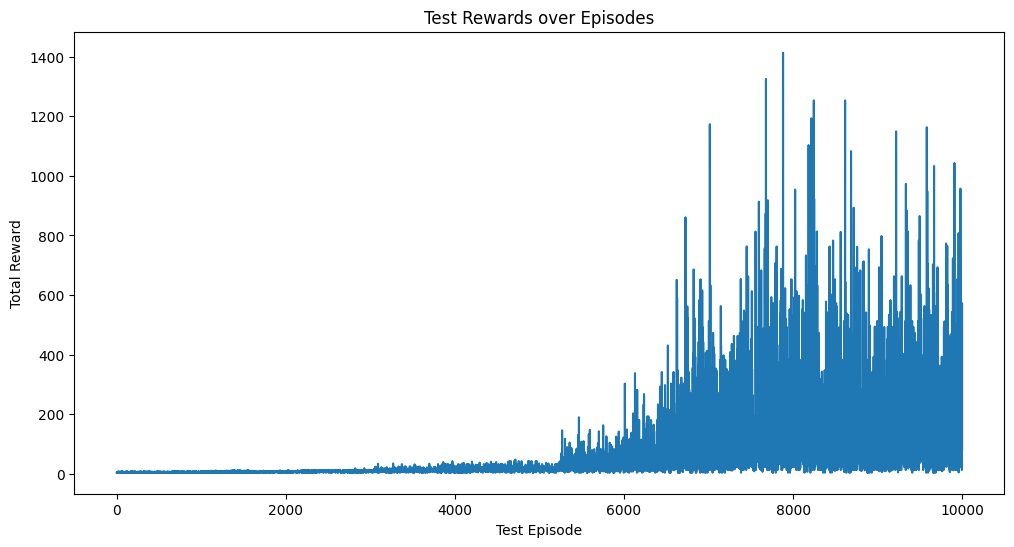

Mean Test Score: 5.882
Median Test Score: 0.0
Max Test Score: 140


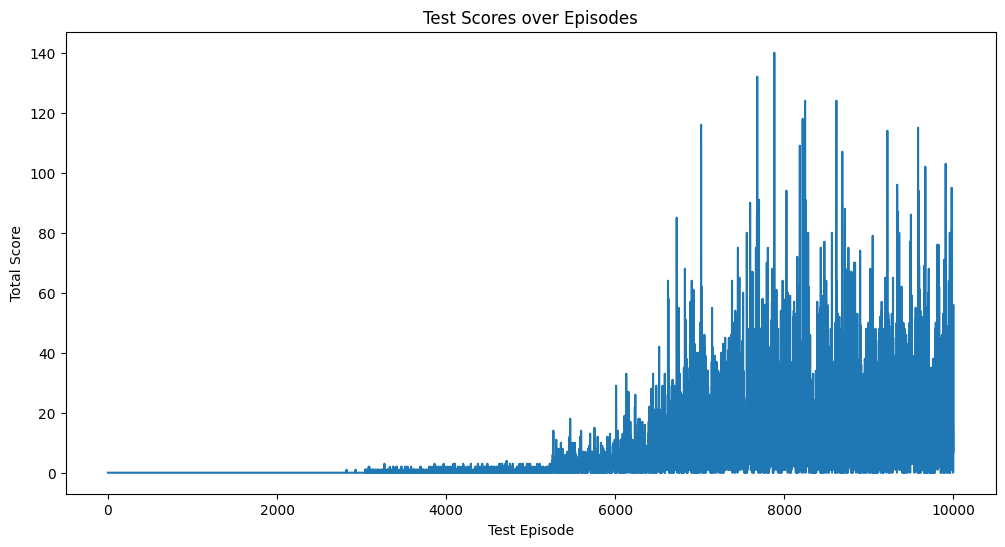

In [6]:
# Define the best hyperparameters found from previous tuning
best_alpha = 0.2
best_epsilon = 0.05
best_gamma = 1
best_lambda = 0.3

# Initialize the environment
env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)

# Initialize the optimal SarsaLambdaAgent with the best hyperparameters
optimal_agent = SarsaLambdaAgent(n_actions=2, eps=best_epsilon, alpha=best_alpha, gamma=best_gamma, lambd=best_lambda)

# Train the optimal agent
n_episodes = 10000
test_rewards,test_scores = train_sarsa_lambda_agent(optimal_agent, env, n_episodes)


mean_test_reward = np.mean(test_rewards)
median_test_reward = np.median(test_rewards)
max_test_reward = np.max(test_rewards)

mean_test_scores = np.mean(test_scores)
median_test_scores = np.median(test_scores)
max_test_scores = np.max(test_scores)

print(f"Mean Test Reward: {mean_test_reward}")
print(f"Median Test Reward: {median_test_reward}")
print(f"Max Test Reward: {max_test_reward}")

# Plotting the test rewards
plt.figure(figsize=(12, 6))
plt.plot(test_rewards)
plt.xlabel('Test Episode')
plt.ylabel('Total Reward')
plt.title('Test Rewards over Episodes')
plt.show()

print(f"Mean Test Score: {mean_test_scores}")
print(f"Median Test Score: {median_test_scores}")
print(f"Max Test Score: {max_test_scores}")

# Plotting the test rewards
plt.figure(figsize=(12, 6))
plt.plot(test_scores)
plt.xlabel('Test Episode')
plt.ylabel('Total Score')
plt.title('Test Scores over Episodes')
plt.show()



#### Performance Graphs

##### Covergence Time

In [14]:

# Best hyperparameters identified from tuning
best_alpha = 0.2
best_epsilon = 0.05
best_gamma = 1
best_lambda = 0.3

# Set up a list of episodes to test
num_episodes_list = [1000, 2000, 3000, 4000,5000,6000,7000,8000,9000,10000]

# Set up a list to store the average rewards
avg_rewards = []
avg_scores = []

# Loop through each episode count
for num_episodes in num_episodes_list:

    # Initialize the environment and agent
    env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)
    agent = SarsaLambdaAgent(n_actions=2, eps=best_epsilon, alpha=best_alpha, gamma=best_gamma, lambd=best_lambda)

    # Train the agent
    training_rewards, training_scores = train_sarsa_lambda_agent(agent, env, num_episodes)

    # Calculate the average reward for the training
    avg_reward = np.mean(training_rewards[-100:])  # Average of the last 100 episodes to assess convergence
    avg_score = np.mean(training_scores[-100:])
    # Add the average reward to the list
    avg_rewards.append(avg_reward)
    avg_scores.append(avg_score)



Training Episodes: 100%|██████████| 10000/10000 [09:21<00:00, 17.80it/s]


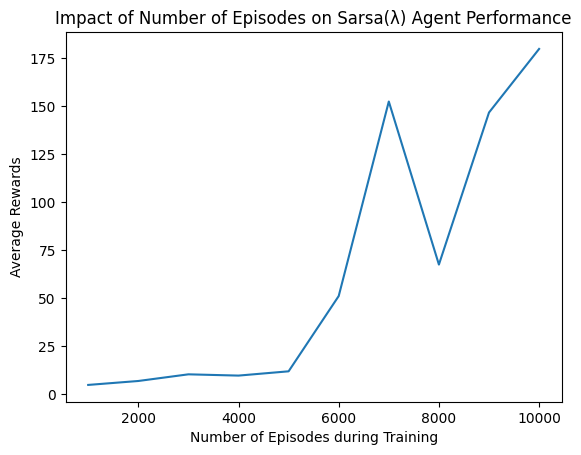

In [15]:
# Plot the performance graph
plt.plot(num_episodes_list, avg_rewards)
plt.xlabel("Number of Episodes during Training")
plt.ylabel("Average Rewards")
plt.title("Impact of Number of Episodes on Sarsa(λ) Agent Performance")
plt.show()

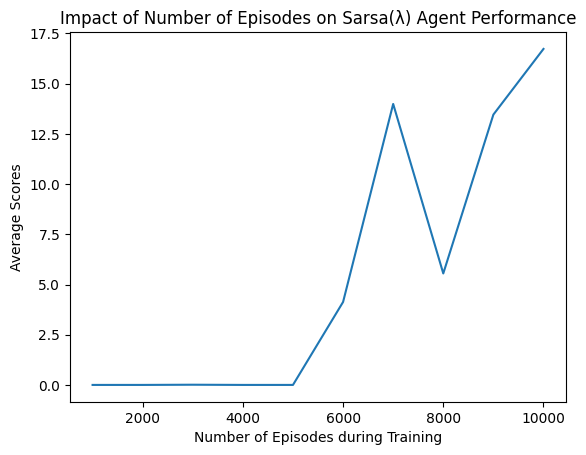

In [16]:
# Plot the performance graph
plt.plot(num_episodes_list, avg_scores)
plt.xlabel("Number of Episodes during Training")
plt.ylabel("Average Scores")
plt.title("Impact of Number of Episodes on Sarsa(λ) Agent Performance")
plt.show()

##### Generalization

Training Episodes: 100%|██████████| 40/40 [00:07<00:00,  5.45it/s]


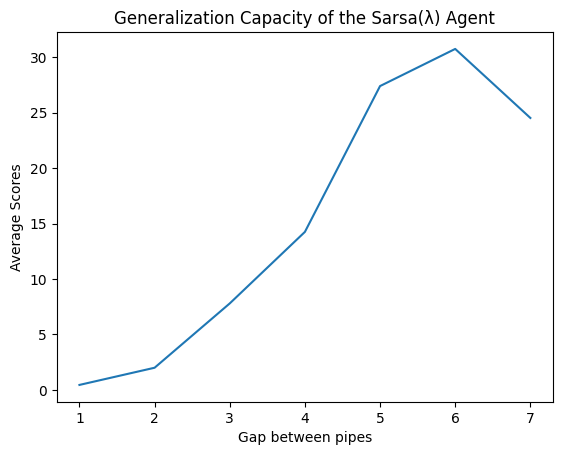

In [23]:
# Set up a list of pipe gaps to test
pipe_gap_list = [1, 2, 3, 4, 5, 6, 7]

avg_scores = []


# Loop through each pipe gap
for pipe_gap in pipe_gap_list:

    env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=pipe_gap)

    rewards, scores = train_sarsa_lambda_agent(agent, env, 40)

    scores = np.mean(scores)

    avg_scores.append(scores)

# Plot the parameter sweep graph for generalization
plt.plot(pipe_gap_list, avg_scores)
plt.xlabel("Gap between pipes")
plt.ylabel("Average Scores")
plt.title("Generalization Capacity of the Sarsa(λ) Agent")
plt.show()


#### State Value Functions Plots




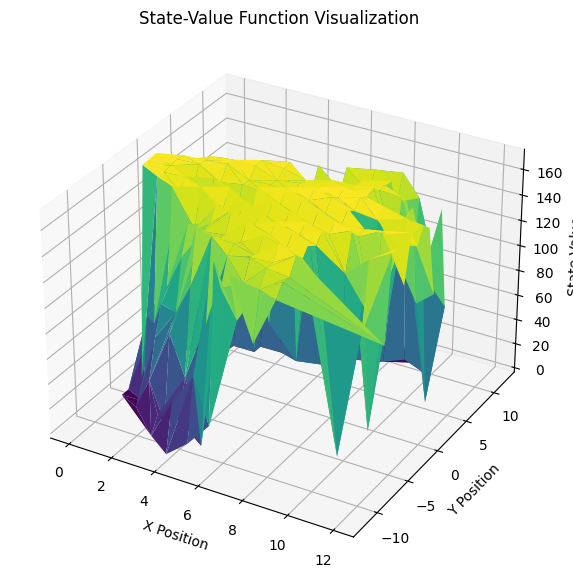

In [25]:
from mpl_toolkits.mplot3d import Axes3D

def calculate_state_value_function(agent):
      v_table = defaultdict(float)
      for state, actions in agent.q_table.items():
          v_table[state] = np.max(actions)
      return v_table

v_table = calculate_state_value_function(optimal_agent)
x_list = []
y_list = []
z_list = []

for state, value in v_table.items():
    if state.startswith("(("):
        try:
            core_state_str = state.split(", {")[0] + ")"
            core_state = eval(core_state_str)
            x, y = core_state[0]
        except Exception as e:
            continue
    else:
        try:
            x, y = eval(state)
        except Exception as e:
            continue

    x_list.append(x)
    y_list.append(y)
    z_list.append(value)

# Plotting
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(x_list, y_list, z_list, cmap='viridis')

ax.set_title('State-Value Function Visualization')
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
ax.set_zlabel('State Value')

plt.show()

### Monte Carlo Agent

In [26]:
class MonteCarlo:
    def __init__(self, gamma, epsilon=0.1):


        self.gamma = gamma
        self.epsilon = epsilon
        self.Q = defaultdict(lambda: 0)
        self.N = defaultdict(lambda: 0)

    def choose_action(self, state):


        if np.random.uniform(0, 1) < self.epsilon:
            return np.random.randint(2)
        else:
            return np.argmax([self.Q[(state,0)],self.Q[(state,1)]])

    def update_Q(self, episode):


        G = 0
        visited = set()
        for t in reversed(range(len(episode))):
            state, action, reward = episode[t]
            G = self.gamma * G + reward
            if (state, action) not in visited:
                self.N[(state, action)] += 1
                self.Q[(state, action)] += (G - self.Q[state, action]) / self.N[state, action]
                visited.add((state, action))

    def train(self,env, n_episodes):

        rewards = []
        scores=[]
        for i in tqdm(range(n_episodes)):
            state,_ = env.reset()
            done = False
            episode = []
            episode_reward = 0
            while not done:
                action = self.choose_action(state)
                next_state, reward,done,_, info = env.step(action)
                episode.append((state, action, reward))
                episode_reward += reward
                state = next_state
            self.update_Q(episode)
            rewards.append(episode_reward)
            scores.append(info['score'])
        return rewards,scores

    def test(self,env, n_episodes):

        rewards = []
        scores=[]
        for i in tqdm(range(n_episodes)):
            state,_ = env.reset()
            done = False
            episode_reward = 0
            while not done:
                action = np.argmax([self.Q[state,0],self.Q[state,1]])
                next_state, reward,done,_, info = env.step(action)
                episode_reward += reward
                state = next_state
                if info['score'] >=1500:
                    break
            rewards.append(episode_reward)
            scores.append(info['score'])
        return rewards,scores

#### Baseline

100%|██████████| 10000/10000 [00:09<00:00, 1032.21it/s]


Average reward over 10000 train episodes: 21.5825
Median reward over 10000 train episodes: 13.0


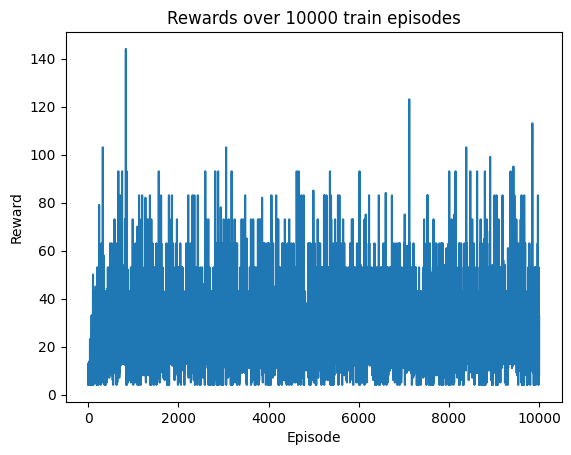

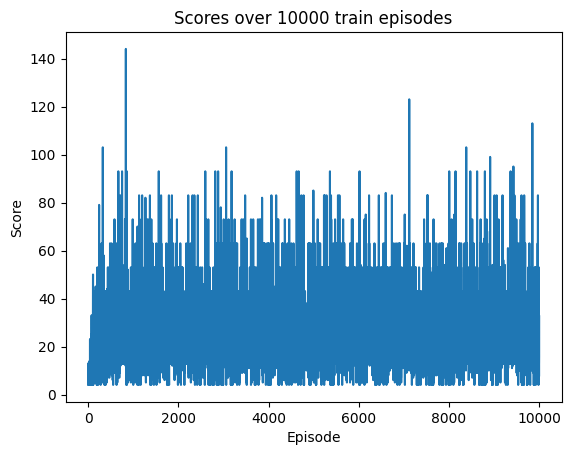

In [27]:
env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)


n_episodes = 10000
mc_agent = MonteCarlo(gamma=0.5, epsilon=0.5)

# train the Monte Carlo agent
train_rewards, train_scores = mc_agent.train(env,n_episodes)

print(f"Average reward over {n_episodes} train episodes:", np.mean(train_rewards))
print(f"Median reward over {n_episodes} train episodes:", np.median(train_rewards))


# plot the rewards
plt.plot(train_rewards)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title(f"Rewards over {n_episodes} train episodes")
plt.show()

# plot the scores
plt.plot(train_rewards)
plt.xlabel("Episode")
plt.ylabel("Score")
plt.title(f"Scores over {n_episodes} train episodes")
plt.show()

### HyperParameter Tuning

#### Epsilon

In [28]:
labels = ["epsilon = 0.1", "epsilon = 0.2","epsilon = 0.3", "epsilon = 0.4","epsilon = 0.5", "epsilon = 0.6", "epsilon = 0.7"]
epsilon = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)

all_rewards=[]
for eps in epsilon:
    n_episodes = 10000
    mc_agent = MonteCarlo(gamma=0.5, epsilon=eps)

    # train the Monte Carlo agent
    train_rewards, train_scores = mc_agent.train(env,n_episodes)
    all_rewards.append(train_rewards)

100%|██████████| 10000/10000 [00:05<00:00, 1790.40it/s]


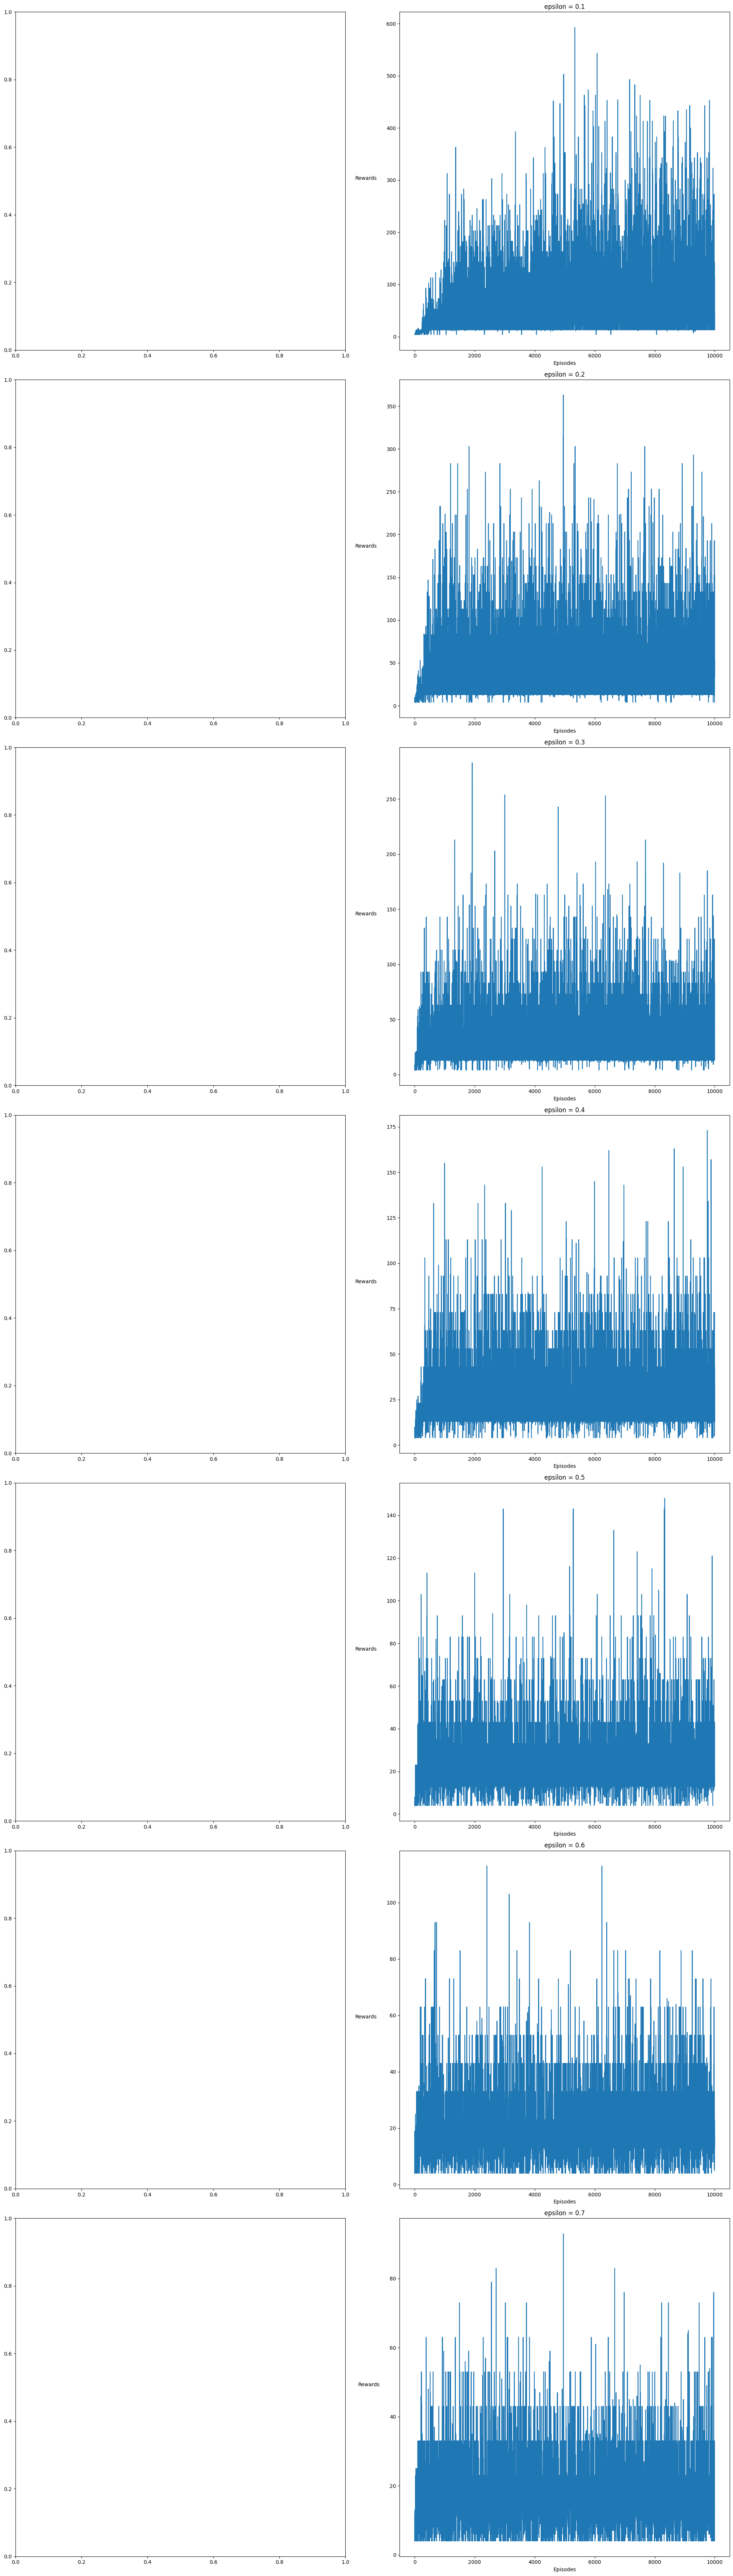

In [29]:
num_rows = len(labels)
num_cols = 2

fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 10*num_rows))

for i in range(num_rows):

    # Plot the rewards
    axs[i, 1].plot(all_rewards[i])
    axs[i, 1].set_xlabel("Episodes")
    axs[i, 1].set_ylabel("Rewards", rotation=0, labelpad=40)
    axs[i, 1].set_title(labels[i])

fig.tight_layout()

plt.show()

In [30]:
headers = ["Label", "Mean(Rewards)", "Median(Rewards)", "Max(Rewards)"]
rows = []

for i in range(len(all_rewards)):
    label = labels[i]
    mean = np.mean(all_rewards[i])
    median = np.median(all_rewards[i])
    maximum = np.max(all_rewards[i])
    rows.append([label, mean, median, maximum])

table = tabulate(rows, headers=headers,tablefmt='fancy_grid')
print(table)




╒═══════════════╤═════════════════╤═══════════════════╤════════════════╕
│ Label         │   Mean(Rewards) │   Median(Rewards) │   Max(Rewards) │
╞═══════════════╪═════════════════╪═══════════════════╪════════════════╡
│ epsilon = 0.1 │         64.6191 │                43 │            593 │
├───────────────┼─────────────────┼───────────────────┼────────────────┤
│ epsilon = 0.2 │         45.8821 │                33 │            363 │
├───────────────┼─────────────────┼───────────────────┼────────────────┤
│ epsilon = 0.3 │         33.2914 │                23 │            283 │
├───────────────┼─────────────────┼───────────────────┼────────────────┤
│ epsilon = 0.4 │         25.2206 │                23 │            173 │
├───────────────┼─────────────────┼───────────────────┼────────────────┤
│ epsilon = 0.5 │         21.6989 │                13 │            148 │
├───────────────┼─────────────────┼───────────────────┼────────────────┤
│ epsilon = 0.6 │         18.7466 │                

#### Gamma

In [31]:
labels = ["Gamma = 0.5", "Gamma = 0.6", "Gamma = 0.7","Gamma = 0.8","Gamma = 0.9","Gamma = 0.9999"]
gamma = [0.5, 0.6, 0.7,0.8,0.9,0.9999]

env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)

all_rewards=[]
for gam in gamma:
    n_episodes = 10000
    mc_agent = MonteCarlo(gamma=gam, epsilon=0.1)
    train_rewards, train_scores = mc_agent.train(env,n_episodes)
    all_rewards.append(train_rewards)

100%|██████████| 10000/10000 [00:21<00:00, 462.94it/s]


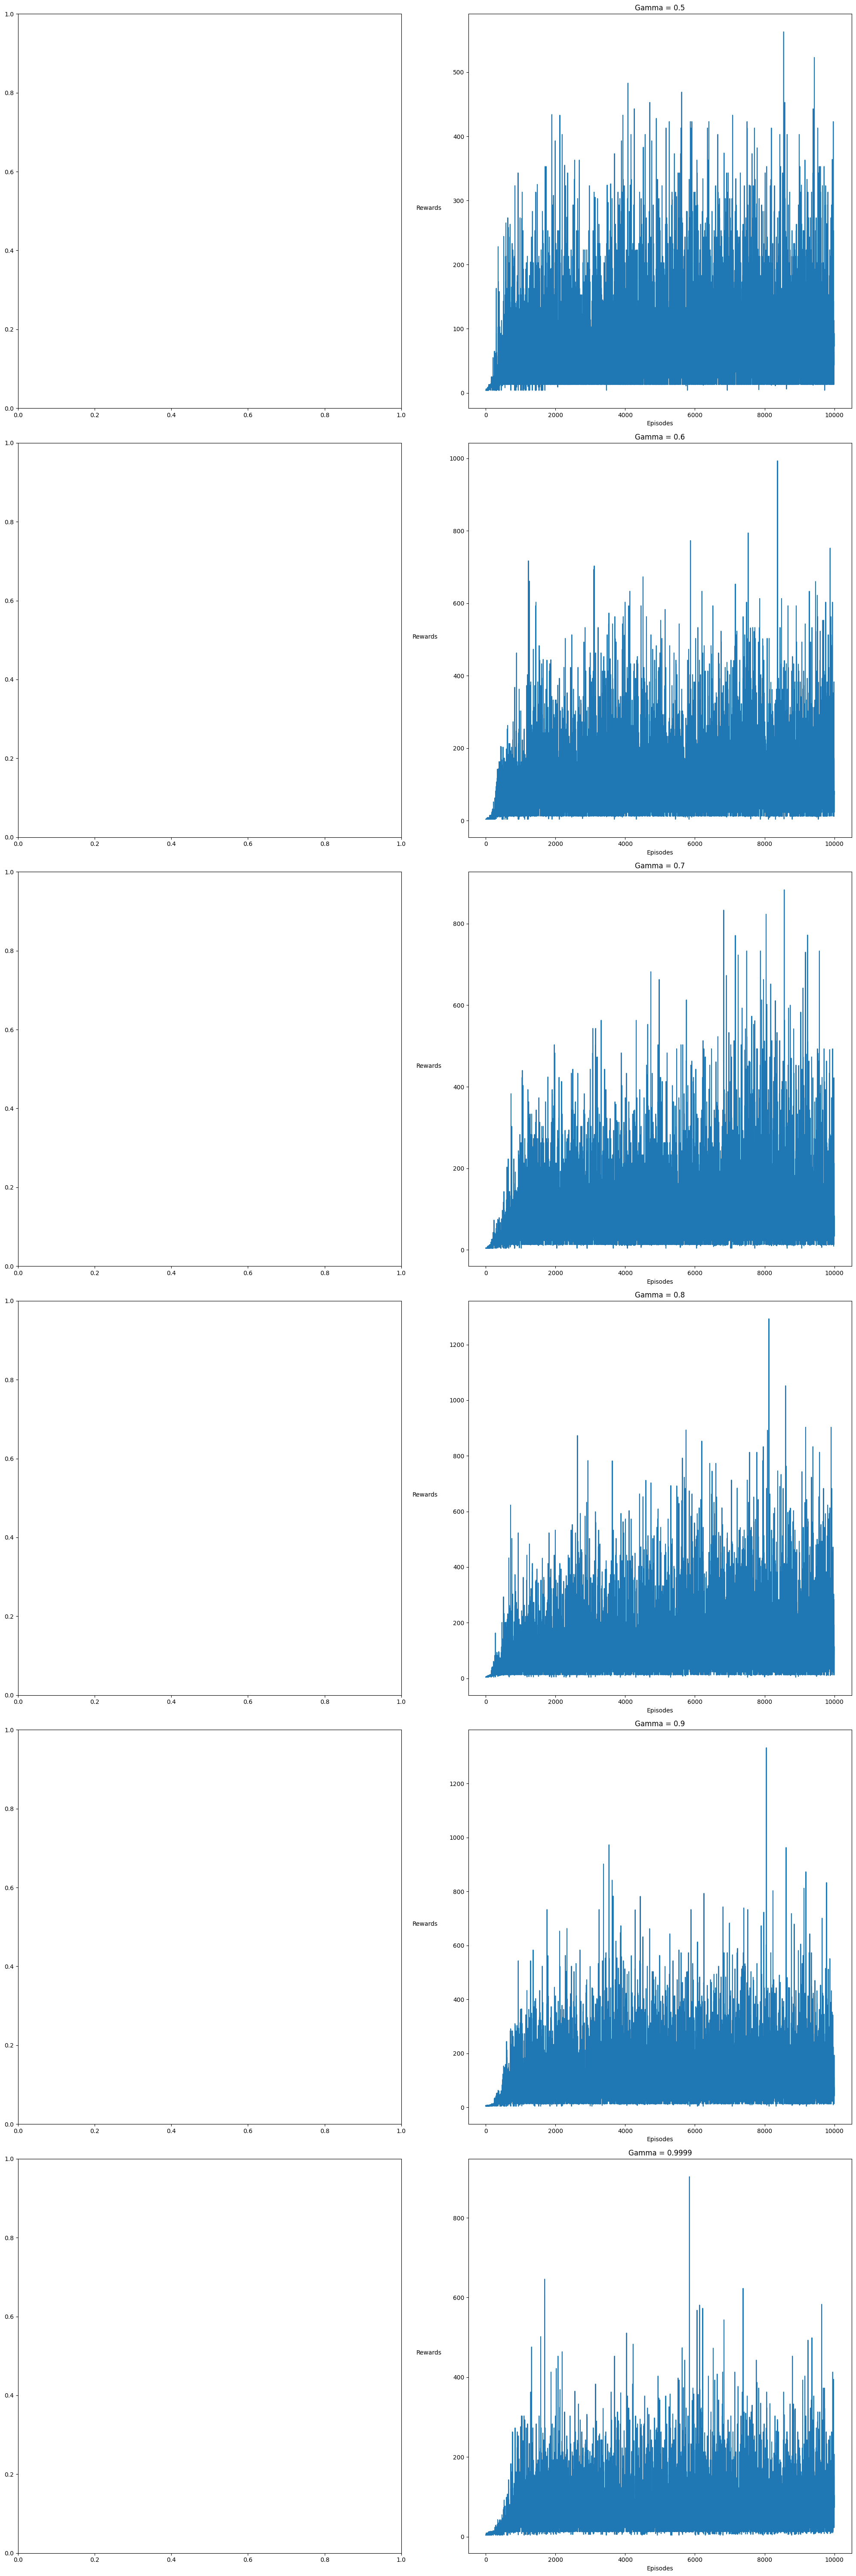

In [33]:
# Define the number of rows and columns
num_rows = len(labels)
num_cols = 2

fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 10*num_rows))

for i in range(num_rows):


    # Plot the rewards
    axs[i, 1].plot(all_rewards[i])
    axs[i, 1].set_xlabel("Episodes")
    axs[i, 1].set_ylabel("Rewards", rotation=0, labelpad=40)
    axs[i, 1].set_title(labels[i])

fig.tight_layout()

# Show the plots
plt.show()

In [34]:
headers = ["Label", "Mean(Rewards)", "Median(Rewards)", "Max(Rewards)"]
rows = []

for i in range(len(all_rewards)):
    label = labels[i]
    mean = np.mean(all_rewards[i])
    median = np.median(all_rewards[i])
    maximum = np.max(all_rewards[i])
    rows.append([label, mean, median, maximum])

table = tabulate(rows, headers=headers,tablefmt='fancy_grid')
print(table)


╒════════════════╤═════════════════╤═══════════════════╤════════════════╕
│ Label          │   Mean(Rewards) │   Median(Rewards) │   Max(Rewards) │
╞════════════════╪═════════════════╪═══════════════════╪════════════════╡
│ Gamma = 0.5    │         72.9874 │                53 │            563 │
├────────────────┼─────────────────┼───────────────────┼────────────────┤
│ Gamma = 0.6    │        102.128  │                73 │            993 │
├────────────────┼─────────────────┼───────────────────┼────────────────┤
│ Gamma = 0.7    │         95.2429 │                63 │            883 │
├────────────────┼─────────────────┼───────────────────┼────────────────┤
│ Gamma = 0.8    │        116.944  │                80 │           1293 │
├────────────────┼─────────────────┼───────────────────┼────────────────┤
│ Gamma = 0.9    │        111.228  │                74 │           1333 │
├────────────────┼─────────────────┼───────────────────┼────────────────┤
│ Gamma = 0.9999 │         67.9385 │  

#### Optimal Model

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
100%|██████████| 10000/10000 [00:35<00:00, 280.13it/s]


Average reward over 10000 train episodes: 105.3496
Median reward over 10000 train episodes: 73.0
Max reward over 10000 train episodes: 1023
Average score over 10000 train episodes: 9.3336
Median score over 10000 train episodes: 6.0
Max score over 10000 train episodes: 101


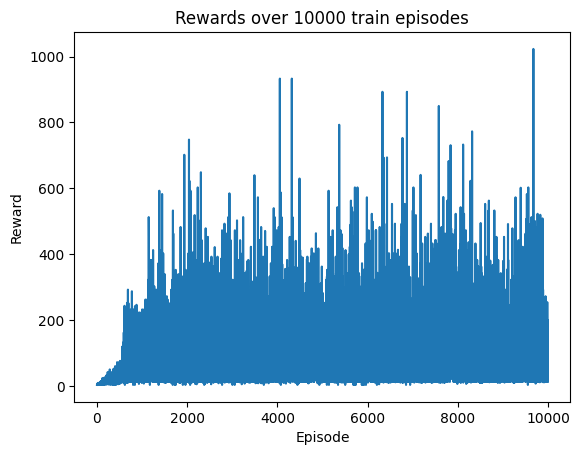

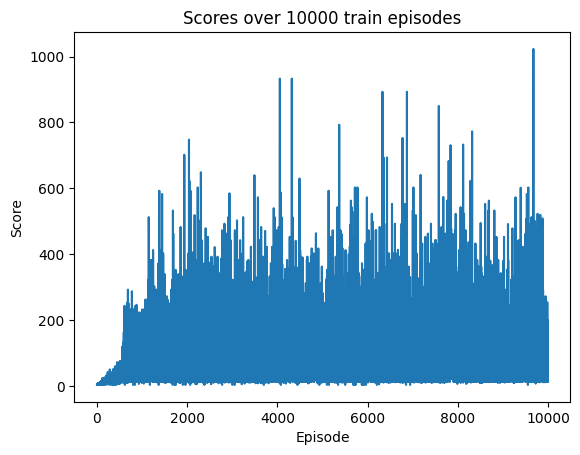

In [42]:
env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)


n_episodes = 10000
# create the Monte Carlo agent
mc_agent = MonteCarlo(gamma=0.9, epsilon=0.1)

# train the Monte Carlo agent
train_rewards, train_scores = mc_agent.train(env,n_episodes)

print(f"Average reward over {n_episodes} train episodes:", np.mean(train_rewards))
print(f"Median reward over {n_episodes} train episodes:", np.median(train_rewards))
print(f"Max reward over {n_episodes} train episodes:", np.max(train_rewards))


print(f"Average score over {n_episodes} train episodes:", np.mean(train_scores))
print(f"Median score over {n_episodes} train episodes:", np.median(train_scores))
print(f"Max score over {n_episodes} train episodes:", np.max(train_scores))


# plot the rewards
plt.plot(train_rewards)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title(f"Rewards over {n_episodes} train episodes")
plt.show()


# plot the scores
plt.plot(train_rewards)
plt.xlabel("Episode")
plt.ylabel("Score")
plt.title(f"Scores over {n_episodes} train episodes")
plt.show()


#### Performance Graphs

##### Convergence Time

100%|██████████| 5000/5000 [00:15<00:00, 312.69it/s]


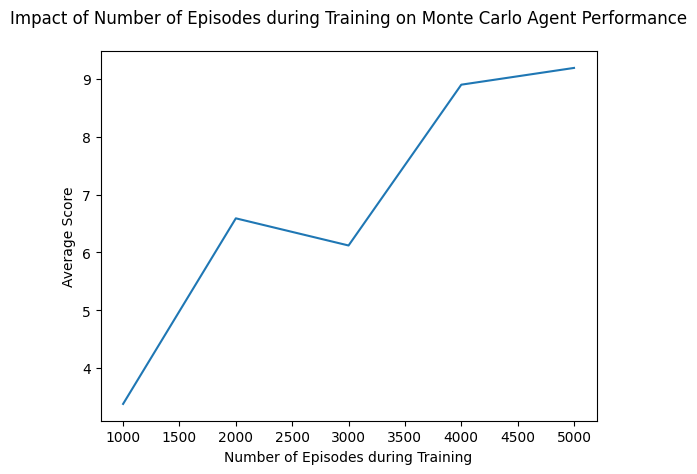

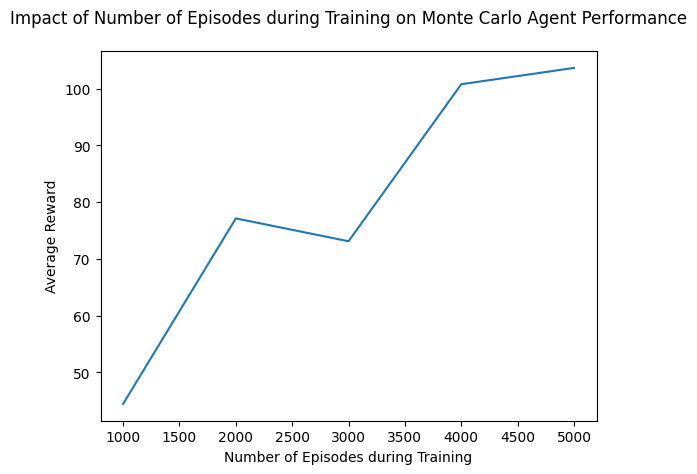

In [36]:
# Set up a list of episodes to test
num_episodes_list = [1000, 2000, 3000, 4000, 5000]

# Set up a list to store the average scores/rewards
avg_scores = []
avg_rewards= []

# Loop through each episode count
for num_episodes in num_episodes_list:

    # Initialize the environment
    env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)

    # Train the Monte Carlo agent on the specified number of episodes
    mc_agent = MonteCarlo(gamma=0.9, epsilon=0.1)
    test_rewards,test_scores = mc_agent.train(env,num_episodes)

    avg_score = np.mean(test_scores)
    avg_reward = np.mean(test_rewards)

    avg_scores.append(avg_score)
    avg_rewards.append(avg_reward)

# Plot the parameter sweep graph
plt.plot(num_episodes_list, avg_scores)
plt.xlabel("Number of Episodes during Training")
plt.ylabel("Average Score")
plt.title("Impact of Number of Episodes during Training on Monte Carlo Agent Performance", pad=20)
plt.show()


# Plot the parameter sweep graph
plt.plot(num_episodes_list, avg_rewards)
plt.xlabel("Number of Episodes during Training")
plt.ylabel("Average Reward")
plt.title("Impact of Number of Episodes during Training on Monte Carlo Agent Performance", pad=20)
plt.show()

##### Generalisation

100%|██████████| 4000/4000 [00:29<00:00, 134.83it/s]


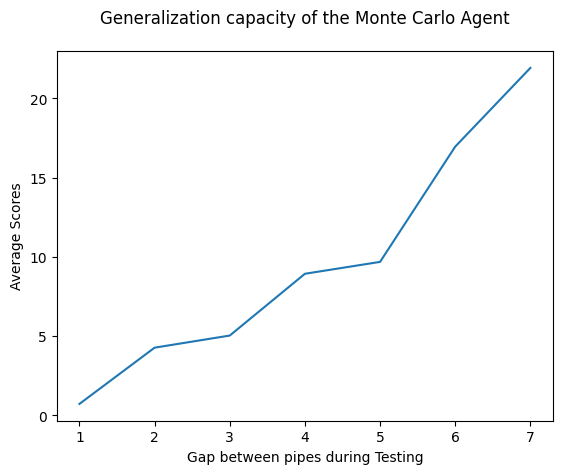

In [37]:
# Set up a list of pipe gap to test
pipe_gap_list = [1, 2, 3,4,5,6,7]

# Set up a list to store the average scores/rewards
avg_scores = []
avg_rewards= []



for pipe_gap in pipe_gap_list:

    # Initialize the environment with the pipe gap
    env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=pipe_gap)
    mc_agent = MonteCarlo(gamma=0.9, epsilon=0.1)
    test_rewards,test_scores = mc_agent.train(env,4000)

    # Calculate the average score for the test set
    avg_score = np.mean(test_scores)
    avg_reward = np.mean(test_rewards)

    avg_scores.append(avg_score)
    avg_rewards.append(avg_reward)

# Plot the parameter sweep graph
plt.plot(pipe_gap_list, avg_scores)
plt.xlabel("Gap between pipes during Testing")
plt.ylabel("Average Scores")
plt.title("Generalization capacity of the Monte Carlo Agent", pad=20)
plt.show()

#### State-Value Functions Plots


In [38]:
def get_statevalue(x, y, Q):

    state = (x, y)
    returns = []
    actions = [0, 1]  # Possible actions in the game

    # Loop over all possible actions and calculate their returns
    for action in actions:
        next_state = ((x+1, y+1),action)  # The next state after taking the given action
        if next_state in list(Q.keys()):
            returns.append(Q[next_state])
        else:
            returns.append(0.0)

    # Calculate the state-value as the average of the returns
    if len(returns) > 0:
        state_value = np.mean(returns)
    else:
        state_value = 0.0

    return state_value

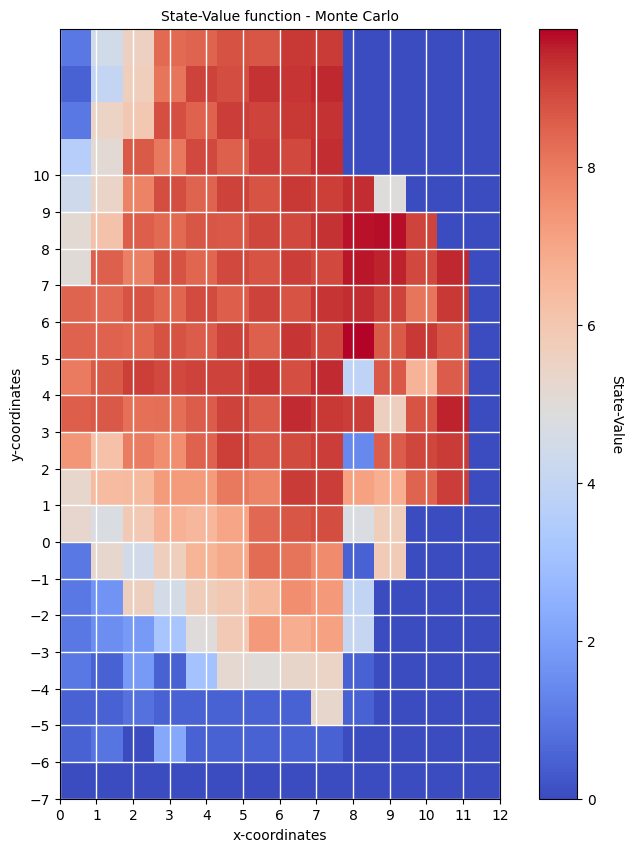

In [39]:
# Get the range of x/y-axis for the plot
x_values_MC = []
y_values_MC = []
for state in mc_agent.Q.keys():
    x = state[0][0]
    y = state[0][1]
    if x not in x_values_MC:
        x_values_MC.append(x)
    if y not in y_values_MC:
        y_values_MC.append(y)
# Prepare the plot
x_range = sorted(x_values_MC)
y_range = sorted(y_values_MC)

X, Y = np.meshgrid(x_range, y_range)
Z = np.array([[get_statevalue(x, y, mc_agent.Q) for x in x_range] for y in y_range])

# Generate the plot
plt.figure(figsize=(10, 10))
plt.xticks(x_range)
plt.yticks(y_range)
surf = plt.imshow(Z, cmap=plt.get_cmap('coolwarm'), extent=[0, 12, -7, 14])
plt.title('State-Value function - Monte Carlo', fontsize='medium')
plt.xlabel('x-coordinates')
plt.ylabel('y-coordinates')
plt.grid(color='w', linestyle='-', linewidth=1)
cbar = plt.colorbar(surf)
cbar.ax.set_ylabel('State-Value', rotation=270, labelpad=20)
plt.show()